# Importing Libraries and Data

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, stopwords
import re
import seaborn as sns
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense, Input, merge, concatenate, Dropout, BatchNormalization
from keras import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# EDA

In [4]:
train_df.shape

(404290, 6)

In [5]:
train_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Distribution of Target Class 

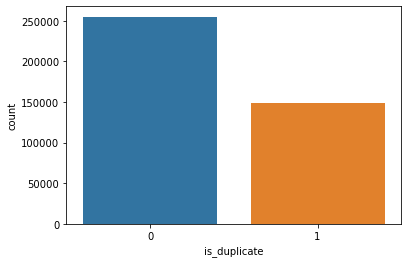

In [6]:
sns.countplot(train_df["is_duplicate"]);

## Questions Analysis 

In [7]:
train_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [8]:
train_df["question1"] = train_df["question1"].astype(str)
train_df["question2"] = train_df["question2"].astype(str)

In [9]:
max(train_df["question2"].apply(len))

1169

### Distributions of Questions 

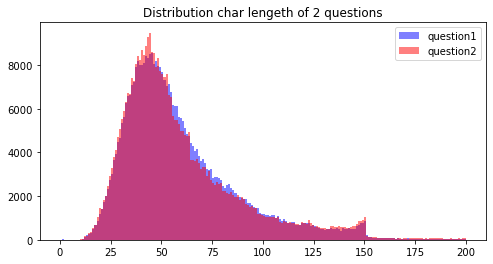

In [10]:
plt.figure(figsize = (8,4))
plt.hist(train_df["question1"].apply(len), bins = 200, range = [0,200], color = "b", alpha = 0.5)
plt.hist(train_df["question2"].apply(len), bins = 200, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution char lengeth of 2 questions")
plt.legend(["question1", "question2"]);

The 2 questions have almost identical distribution  in terms of number of characters

### Distribution of difference in lengths by class 

In [11]:
len1 = train_df["question1"].apply(len)
len2 = train_df["question2"].apply(len)
diff_len = np.abs(len1-len2) 

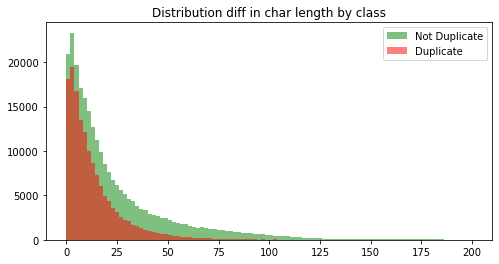

In [12]:
plt.figure(figsize = (8,4))
plt.hist(diff_len[train_df["is_duplicate"]==0], bins = 100, range = [0,200], color = "g", alpha =0.5)
plt.hist(diff_len[train_df["is_duplicate"]==1], bins = 100, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution diff in char length by class")
plt.legend(["Not Duplicate", "Duplicate"]);

No significant diff in lengths between 2 classes

## Cleaning the data 
Steps:
- Lowercase
- Tokenize
- Remove Stopwords
- Remove non alphabet characters

In [81]:
def clean_data(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stopwords.words("english") and w.isalnum()]
    return words

In [82]:
q1 = train_df["question1"].apply(clean_data)
q2 = train_df["question2"].apply(clean_data)

# Predictive Modeling

In [85]:
RANDOM_STATE = 24

In [86]:
ind_train , ind_test, y_train, y_test = train_test_split(np.arange(0,train_df.shape[0]), train_df["is_duplicate"], train_size = 0.95, stratify = train_df["is_duplicate"], random_state = RANDOM_STATE)

## Char Counts - Cosine Similarity Approach
- Lemmatize both Questions
- Count characters (1-6)
- Find cosine similarity between 2 questions' char counts
- Apply logistic regression for probabilities

### Lemmatize

In [93]:
lemma = WordNetLemmatizer()
def lemmatize(text):
    return [lemma.lemmatize(w) for w in text]    

In [94]:
q1_lem = q1.apply(lemmatize)
q2_lem = q2.apply(lemmatize) 

In [95]:
q1_sent = q1_lem.apply(" ".join)
q2_sent = q2_lem.apply(" ".join)

In [98]:
X_clean = pd.DataFrame({"q1":q1_sent, "q2":q2_sent})
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]
X_clean.to_csv("X_clean.csv", index = False)

### Cosine Similarity

In [99]:
Questions_train = pd.concat([X_train["q1"], X_train["q2"]], axis = 0)

In [100]:
count_vect = CountVectorizer(analyzer = "char", ngram_range = (2,8))
count_vect.fit(Questions_train);

In [101]:
charc_q1_train = count_vect.transform(X_train["q1"])
charc_q2_train = count_vect.transform(X_train["q2"])
charc_q1_test = count_vect.transform(X_test["q1"])
charc_q2_test = count_vect.transform(X_test["q2"])

In [111]:
def cosine_sim(vect1, vect2):
    cos_sim = np.empty([vect1.shape[0], 1])
    for i,vs in enumerate(zip(vect1, vect2)):
        cos_sim[i] = (float(cosine_similarity(vs[0], vs[1])))
    return cos_sim

In [117]:
cosine_sim(charc_q1_train[0:100], charc_q2_train[0:100])


array([[0.71224583],
       [0.84946237],
       [0.83535193],
       [1.        ],
       [0.64556512],
       [1.        ],
       [0.75485136],
       [0.16040195],
       [0.40135598],
       [0.78984044],
       [0.43251142],
       [0.53452248],
       [0.51730122],
       [0.21177936],
       [0.02723737],
       [0.25712974],
       [0.38953284],
       [0.08378309],
       [0.84946237],
       [0.63245553],
       [0.        ],
       [0.04694946],
       [0.68092286],
       [1.        ],
       [0.29662053],
       [1.        ],
       [0.653795  ],
       [0.70680628],
       [1.        ],
       [0.1633301 ],
       [0.91893658],
       [0.3770408 ],
       [0.64843404],
       [0.59942461],
       [0.84515425],
       [0.68080952],
       [0.47460481],
       [0.73046623],
       [0.24003968],
       [0.43492389],
       [1.        ],
       [0.67185481],
       [0.31676112],
       [0.66985495],
       [0.5       ],
       [0.60424462],
       [1.        ],
       [0.443

### Logistic Regression

In [ ]:
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]

In [ ]:
Summary_CS = pd.DataFrame(columns = ["Model", "Test Log Loss"])

In [ ]:
lr = LogisticRegression()
lr.fit(X_train[["cos_sim"]], y_train);

In [60]:
preds_train = lr.predict_proba(X_train[["cos_sim"]])[:,1]

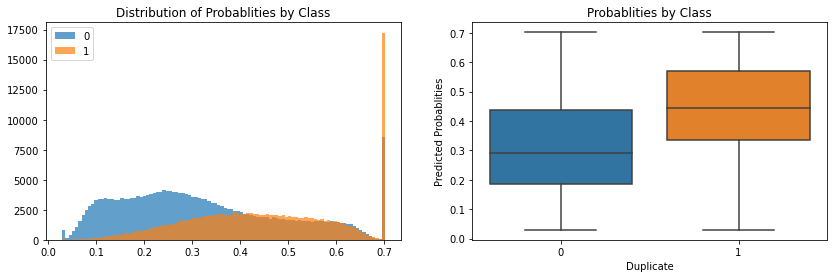

In [61]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [65]:
preds_test = lr.predict_proba(X_test[["cos_sim"]])[:,1]
log_loss = log_loss(y_test, preds_test)

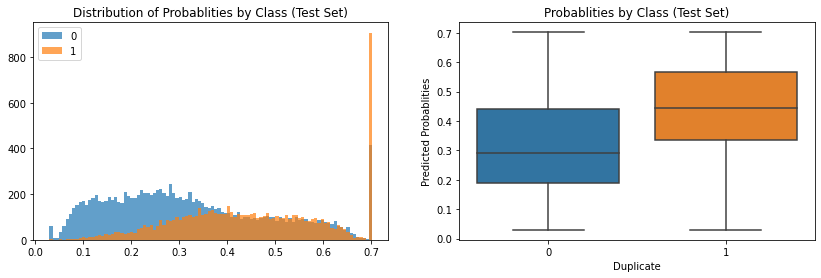

In [63]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [68]:
Summary_CS  = Summary_CS.append({"Model":"Logistic Regression", "Test Log Loss":log_loss}, ignore_index = True)

In [69]:
Summary_CS

,Model,Test Log Loss
0,Logistic Regression,0.589266


## Tf-idf characters - Cosine Similarity Approach
- Lemmatize both Questions
- Tf-idf characters (1-6)
- Find cosine similarity between 2 questions' tf-idf
- Apply logistic regression for probabilities

### Tf-idf

In [55]:
tfidf_vect = TfidfVectorizer(analyzer = "char", ngram_range = (1,6))
def cosine_sim(vectorizer,row):
    q1 = str(row["q1"])
    q2 = str(row["q2"])
    try:
        vectors = vectorizer.fit_transform([str(row["q1"]),str(row["q2"])]).toarray()
        return float(cosine_similarity(vectors)[0][1])
    except: 
        return 0

In [56]:
X_clean["cos_sim"] = X_clean.apply(cosine_sim, axis = 1)

### Logistic Regression

In [57]:
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]

In [213]:
preds = lr.predict_proba(X_test[["cos_sim"]])[:,1]

In [218]:
log_loss(y_test, np.zeros(len(y_test)))

12.751070404908159

array([1., 1., 1., ..., 1., 1., 1.])

In [75]:
q1_new = q1.apply(" ".join)
q2_new = q2.apply(" ".join)

In [137]:
VOCAB_SIZE = 50
encod_q1 = [one_hot(q1, VOCAB_SIZE) for q1 in q1_new]
encod_q2 = [one_hot(q2, VOCAB_SIZE) for q2 in q2_new]

In [138]:
pad_q1 = pad_sequences(encod_q1, maxlen = 50, padding = "post", value = 0)
pad_q2 = pad_sequences(encod_q2, maxlen = 96, padding = "post", value = 0)

In [147]:
input_q1 = Input(shape = (50,))
embedding_q1 = Embedding(VOCAB_SIZE, 100, input_length=50)(input_q1)
layer_q1 = Flatten()(embedding_q1)
layer_q1 = Dense(32, activation='relu')(layer_q1)

In [148]:
input_q2 = Input(shape = (96,))
embedding_q2 = Embedding(VOCAB_SIZE, 100, input_length=96)(input_q2)
layer_q2 = Flatten()(embedding_q2)
layer_q2 = Dense(32, activation='relu')(layer_q2)

In [149]:
merge_q = concatenate([layer_q1, layer_q2])
merge_q = BatchNormalization()(merge_q)

In [150]:
merge_q = Dense(64, activation='relu')(merge_q)
merge_q = BatchNormalization()(merge_q)
merge_q = Dropout(0.2)(merge_q)

In [151]:
preds = Dense(1, activation='sigmoid')(merge_q)

In [152]:
model = Model(inputs=[input_q1,input_q2], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [153]:
model.fit([pad_q1,pad_q2], np.array(train_df["is_duplicate"]),  validation_split =0.2,  epochs=10, batch_size=1024, shuffle=True)

C:\Users\Onkar\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 323432 samples, validate on 80858 samples
Epoch 1/10
323432/323432 [==============================] - 21s 65us/step - loss: 0.6173 - acc: 0.6519 - val_loss: 0.6338 - val_acc: 0.6394
Epoch 2/10
323432/323432 [==============================] - 20s 62us/step - loss: 0.5738 - acc: 0.6899 - val_loss: 0.6146 - val_acc: 0.6550
Epoch 3/10
323432/323432 [==============================] - 21s 65us/step - loss: 0.5558 - acc: 0.7021 - val_loss: 7.3457 - val_acc: 0.6403
Epoch 4/10
323432/323432 [==============================] - 23s 71us/step - loss: 0.5443 - acc: 0.7106 - val_loss: 0.6188 - val_acc: 0.6702
Epoch 5/10
323432/323432 [==============================] - 22s 68us/step - loss: 0.5374 - acc: 0.7145 - val_loss: 0.9383 - val_acc: 0.5422
Epoch 6/10
323432/323432 [==============================] - 24s 73us/step - loss: 0.5311 - acc: 0.7187 - val_loss: 0.6401 - val_acc: 0.6735
Epoch 7/10
323432/323432 [==============================] - 23s 72us/step - loss: 0.5265 - acc: 0.7218 - val_

In [129]:
model = Model(input=[pad_q1,pad_q2], output=preds)

C:\Users\Onkar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[array([[3..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


ValueError: Input tensors to a Model must come from `keras.layers.Input`. Received: [[34 34 19 ...  0  0  0]
 [48 41  6 ...  0  0  0]
 [27  6  9 ...  0  0  0]
 ...
 [25 35  0 ...  0  0  0]
 [ 7 33 31 ...  0  0  0]
 [38  5 45 ...  0  0  0]] (missing previous layer metadata).

In [ ]:
embedding_layer2 = Embedding(VOCAB_SIZE, 8, input_length=50)